# Here we make a Random Forest Model For Prochlorococcus


In [1]:
# Set a working directory
#!pip install GitPython
import git
import os

repo = git.Repo('.', search_parent_directories=True)


os.chdir(repo.working_tree_dir)

###  Running the model preparation notebook

In [2]:
# Running model preperation notebook that has a function we need to call
%run 'Python/04_Populations-model-fitting/01_model-preparation.ipynb'
#%run '/Users/cristianswift/Desktop/armbrust-lab/Seaflow-Machine-Learning/python/04_Populations-model-fitting/01_model-preparation.ipynb'


(2392, 23)
<class 'numpy.ndarray'>


In [3]:
#loading packages for random forest modeling

from sklearn.model_selection import train_test_split
import joblib
import forestci as fci


Failed to import duecredit due to No module named 'duecredit'


### First we are making a graph to determine the best testing to training ratio 

This is using a function that we defined in notebook 01_model-preparation

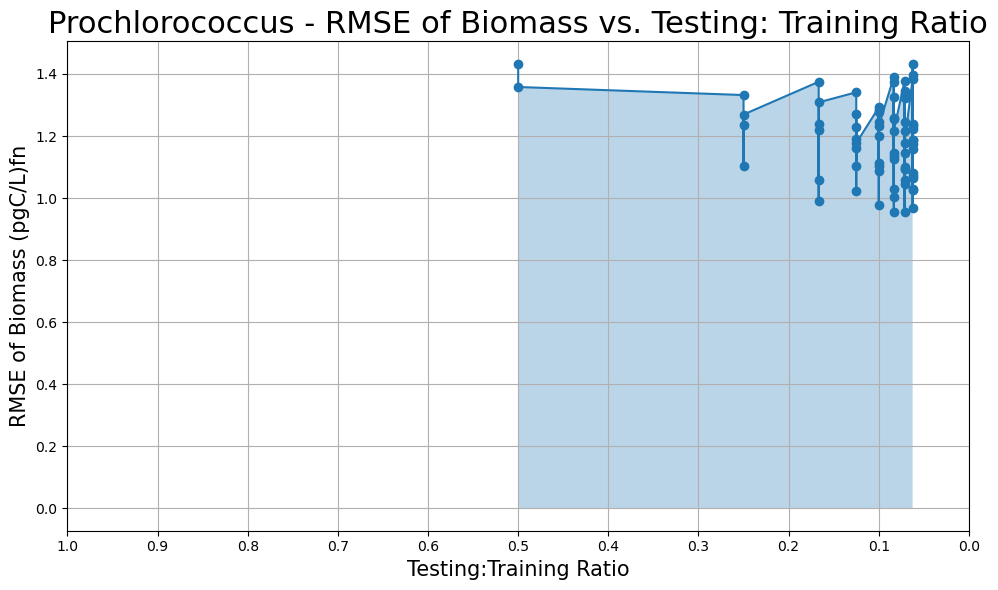

In [4]:
#using a function defined in the model preparation notebook
RMSEs = testing_training_ratio(features = features_pro, labels = labels_pro,
                               feature_list=feature_list_pro, title_prefix="Prochlorococcus")


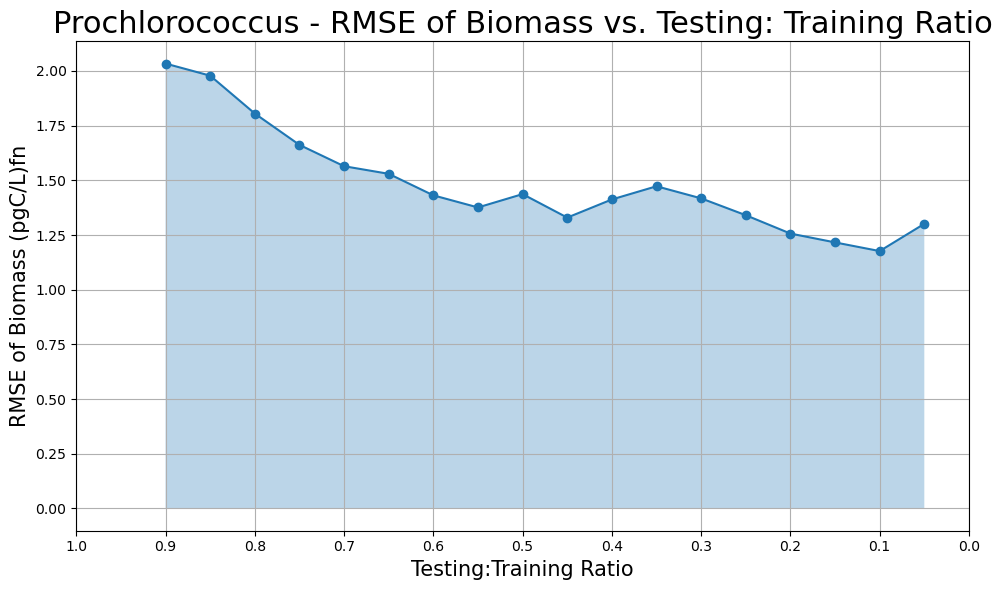

In [5]:
R_RMSEs = testing_training_ratio_random(features = features_pro, labels = labels_pro,
                                        feature_list=feature_list_pro, title_prefix="Prochlorococcus")

## RF Regressor for Prochlorococcus

Here we are first calling a function defined in the model preparation notebook to find the optimal number of decision trees for out model, and then we are assembling a random forest regressor model for the prochlorococcus population.  This is then saved in a joblib file for future use.

In [6]:
from sklearn.model_selection import KFold
import numpy as np

# Define the number of splits for k-fold cross-validation
n_splits = 8
kf = KFold(n_splits=n_splits, shuffle=False)

# Initialize lists to hold training and testing data
train_features = []
test_features = []
train_labels = []
test_labels = []

# Split the data into training and testing sets for each fold
for train_index, test_index in kf.split(features_pro):
    train_feat, test_feat = features_pro[train_index], features_pro[test_index]
    train_lab, test_lab = labels_pro[train_index], labels_pro[test_index]
    
    # Append the training and testing data for this fold to the lists
    train_features.append(train_feat)
    test_features.append(test_feat)
    train_labels.append(train_lab)
    test_labels.append(test_lab)


In [7]:
#plot_oob_error_vs_num_trees(train_features, train_labels, title_prefix="Prochlorococcus")

In [8]:
# Looking at the shape of the features and labels to see if they match up
import numpy
lengths = [len(sublist) for sublist in train_features]
print(set(lengths))
print(type(train_features))
print(type(train_labels))
print(features_pro)
train_features = numpy.array(train_features)
train_labels = numpy.array(train_labels)
test_features = numpy.array(test_features)
test_labels = numpy.array(test_labels)
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

{2093}
<class 'list'>
<class 'list'>
[[ 3.49023765e+01  2.43392647e+01 -2.28452622e-02 ...  1.95487665e+03
   2.03823530e-02  1.58352778e+01]
 [ 3.48805900e+01  2.43207250e+01 -2.19817645e-02 ...  1.95626175e+03
   8.56500000e-02  1.68386111e+01]
 [ 3.48840526e+01  2.43108263e+01 -2.19817645e-02 ...  1.95626175e+03
   8.59157890e-02  1.78419444e+01]
 ...
 [ 3.34713633e+01  1.53143378e+01  3.63295805e-01 ...  2.00841777e+03
   5.68868550e+02  8.14611111e+00]
 [ 3.34681505e+01  1.51890208e+01  3.63295805e-01 ...  2.00841777e+03
   1.27692150e+02  9.14416667e+00]
 [ 3.34788456e+01  1.53273022e+01  3.63295805e-01 ...  2.00841777e+03
   1.01280000e+00  1.01361111e+01]]
Training Features Shape: (8, 2093, 23)
Training Labels Shape: (8, 2093)
Testing Features Shape: (8, 299, 23)
Testing Labels Shape: (8, 299)


In [49]:
# We are using a regressor RF model because we are predicting on continous values
import numpy as np
from sklearn.ensemble import RandomForestRegressor

# Initialize a list to hold the models for each fold
models = []

# Loop over the folds
for i in range(train_features.shape[0]):
    # Instantiate model with 100 decision trees
    rf = RandomForestRegressor(n_estimators = 200, max_depth=16, max_features='sqrt', random_state = 42)
    
    # Use the Training data to build the model
    rf.fit(train_features[i], train_labels[i])
    
    # Append the model to the list
    models.append(rf)

# Save the models
for i, model in enumerate(models):
    joblib.dump(model, f"RF_models/pro_random_forest_fold_{i}.joblib")


In [50]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.ensemble import RandomForestRegressor

# # Define the hyperparameters grid
# param_grid = {
#     'n_estimators': [20, 60, 120, 200, 400],
#     'max_depth': [None, 16, 32, 64],
#     'max_features': ['sqrt', 'log2', None
#                      ]
# }

# # Initialize the model
# rf = RandomForestRegressor(random_state=42)

# numK=[8]

# for i in numK:
#     # Initialize the grid search
#     grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=i, scoring='neg_mean_squared_error', error_score='raise', verbose=3)

#     # Fit the grid search to the data
#     grid_search.fit(features_pro, labels_pro)

#     # Get the best hyperparameters
#     best_params = grid_search.best_params_

#     print(f"Best hyperparameters: {best_params}")

In [51]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import joblib
import pandas as pd
import forestci as fci

# Initialize lists to hold predictions and errors
predictions = []
maes = []
rmses = []
confidence = []
# Loop over the folds
for i in range(test_features.shape[0]):
    # Load the model for this fold
    rf = joblib.load(f"RF_models/pro_random_forest_fold_{i}.joblib")
    
    # Use the model to predict on the test data for this fold
    preds = rf.predict(test_features[i])
    
    # Calculate the errors
    mae = mean_absolute_error(test_labels[i], preds)
    RMSE = mean_squared_error(test_labels[i], preds, squared=False)

    
    confs = fci.random_forest_error(rf, train_features[i], test_features[i])
    

    # Append the predictions and errors to the lists
    predictions.append(preds)
    maes.append(mae)
    rmses.append(RMSE)
    confidence.append(confs)
    # Save the predictions for each fold
    data = {'predictions': preds,
        'reals' : test_labels[i]}
    
    for key, value in data.items():
        print(f"Number of elements in {key}: {np.size(value)}")
    
    actual = pd.DataFrame(data)
    actual.to_csv(f'actual_pro{i}.csv', index=False)


# Convert lists of arrays to 2D arrays

predictions = np.concatenate(predictions)
confidence = np.concatenate(confidence)
maes = np.array(maes)
rmses = np.array(rmses)
rmse = np.sqrt(np.mean(rmses**2))

# Print the mean absolute errors and root mean square errors
print('Mean Absolute Errors:', maes)
print('Root Mean Squared Errors:', rmses)
print('Mean RMSE:', rmse)
print(len(predictions))
print(len(confidence))

/Users/stlp/anaconda3/envs/machine-learning-env/lib/python3.9/site-packages/forestci/calibration.py:86: RuntimeWarning:

overflow encountered in exp



Number of elements in predictions: 299
Number of elements in reals: 299


/Users/stlp/anaconda3/envs/machine-learning-env/lib/python3.9/site-packages/forestci/calibration.py:86: RuntimeWarning:

overflow encountered in exp



Number of elements in predictions: 299
Number of elements in reals: 299


/Users/stlp/anaconda3/envs/machine-learning-env/lib/python3.9/site-packages/forestci/calibration.py:86: RuntimeWarning:

overflow encountered in exp



Number of elements in predictions: 299
Number of elements in reals: 299
Number of elements in predictions: 299
Number of elements in reals: 299
Number of elements in predictions: 299
Number of elements in reals: 299


/Users/stlp/anaconda3/envs/machine-learning-env/lib/python3.9/site-packages/forestci/calibration.py:86: RuntimeWarning:

overflow encountered in exp



Number of elements in predictions: 299
Number of elements in reals: 299
Number of elements in predictions: 299
Number of elements in reals: 299
Number of elements in predictions: 299
Number of elements in reals: 299
Mean Absolute Errors: [1.88432979 1.91263661 1.42464415 1.36857659 1.20239163 3.64035995
 3.04097295 1.50954335]
Root Mean Squared Errors: [2.61741075 2.41786753 1.76857238 2.01414769 1.65128301 4.30144213
 3.93321308 2.00752156]
Mean RMSE: 2.752521787458147
2392
2392


/Users/stlp/anaconda3/envs/machine-learning-env/lib/python3.9/site-packages/forestci/calibration.py:86: RuntimeWarning:

overflow encountered in exp

/Users/stlp/anaconda3/envs/machine-learning-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning:

overflow encountered in reduce

/Users/stlp/anaconda3/envs/machine-learning-env/lib/python3.9/site-packages/forestci/calibration.py:86: RuntimeWarning:

overflow encountered in exp



In [52]:
import pandas as pd

covari_path = 'data/modified/RF_ready_covari.csv'
#using pandas to read in as a df
covari = (pd.read_csv(covari_path,parse_dates=[0]))
#taking a peak at the data
covari.head(3)
covari_pro = covari[covari['population'] == 'Prochlorococcus']
covari_pro.reset_index(drop=True, inplace=True)
covari_pro.head(3)


,time,population,lat,lon,biomass,salin,temp,cruisename,SiO2,POSi,...,FeT,DOP,DON,DOFe,DOC,DIC,CDOM,ALK,par,hours_since_sunrise
0,2016-04-20 07:00:00,Prochlorococcus,21.520326,-158.326984,10.520443,34.893785,24.351745,KOK1606,-0.022845,-0.000127,...,0.000015,0.013734,0.248717,0.000017,1.648093,1697.874775,0.000034,1954.87665,0.019300,14.832778
1,2016-04-20 08:00:00,Prochlorococcus,21.662710,-158.323430,9.309387,34.902376,24.339265,KOK1606,-0.022845,-0.000127,...,0.000015,0.013734,0.248717,0.000017,1.648093,1697.874775,0.000034,1954.87665,0.020382,15.835278
2,2016-04-20 09:00:00,Prochlorococcus,21.802385,-158.305650,9.406512,34.880590,24.320725,KOK1606,-0.021982,-0.000120,...,0.000017,0.012739,0.235864,0.000016,1.528731,1699.677975,0.000031,1956.26175,0.085650,16.838611


In [53]:
original_df = covari_pro.reset_index()

predicted_df = pd.DataFrame(predictions, columns=['prediction'])
#adding header to predictions
head = 'predicted'
header = pd.DataFrame([head], index=[0])
# Concatenate the new row and the existing DataFrame
predicted_df = pd.concat([header, predicted_df]).reset_index()

predicted_df['index'] = original_df.index



conf_df = pd.DataFrame(confidence, columns=['confidence'])
#adding header to predictions
head = 'confidence'
header = pd.DataFrame([head], index=[0])
# Concatenate the new row and the existing DataFrame
conf_df = pd.concat([header, conf_df]).reset_index()

conf_df['index'] = original_df.index




# Merge the two dataframes on the index
merged_df = pd.merge(original_df, predicted_df, on='index')
merged_df = pd.merge(merged_df, conf_df, on='index')
# Set the index back to the original column
merged_df = merged_df.set_index('index')
merged_df.head(5)


,time,population,lat,lon,biomass,salin,temp,cruisename,SiO2,POSi,...,DOC,DIC,CDOM,ALK,par,hours_since_sunrise,0_x,prediction,0_y,confidence
index,,,,,,,,,,,,,,,,,,,,,
0,2016-04-20 07:00:00,Prochlorococcus,21.520326,-158.326984,10.520443,34.893785,24.351745,KOK1606,-0.022845,-0.000127,...,1.648093,1697.874775,0.000034,1954.87665,0.019300,14.832778,predicted,NaN,confidence,NaN
1,2016-04-20 08:00:00,Prochlorococcus,21.662710,-158.323430,9.309387,34.902376,24.339265,KOK1606,-0.022845,-0.000127,...,1.648093,1697.874775,0.000034,1954.87665,0.020382,15.835278,NaN,6.609806,NaN,1.236002
2,2016-04-20 09:00:00,Prochlorococcus,21.802385,-158.305650,9.406512,34.880590,24.320725,KOK1606,-0.021982,-0.000120,...,1.528731,1699.677975,0.000031,1956.26175,0.085650,16.838611,NaN,6.291519,NaN,1.313936
3,2016-04-20 10:00:00,Prochlorococcus,21.943210,-158.289675,9.142002,34.884053,24.310826,KOK1606,-0.021982,-0.000120,...,1.528731,1699.677975,0.000031,1956.26175,0.085916,17.841944,NaN,6.084734,NaN,1.052321
4,2016-04-20 11:00:00,Prochlorococcus,22.081630,-158.284815,8.748631,34.882005,24.312820,KOK1606,-0.021982,-0.000120,...,1.528731,1699.677975,0.000031,1956.26175,0.017300,18.844722,NaN,6.028850,NaN,0.939832


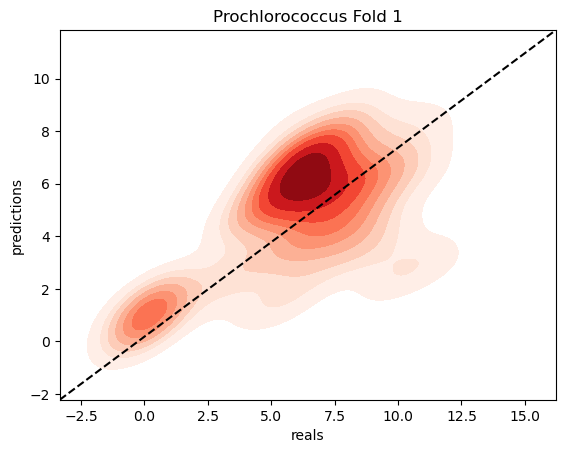

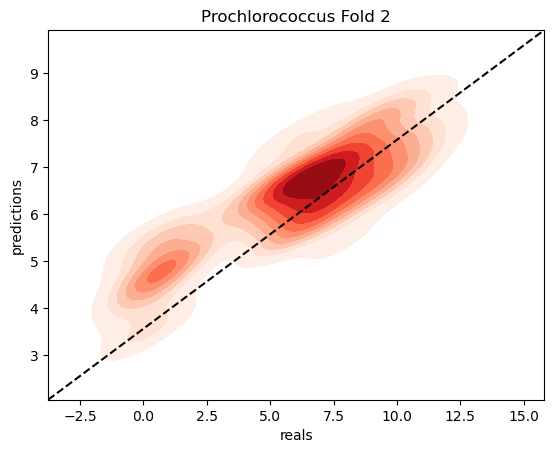

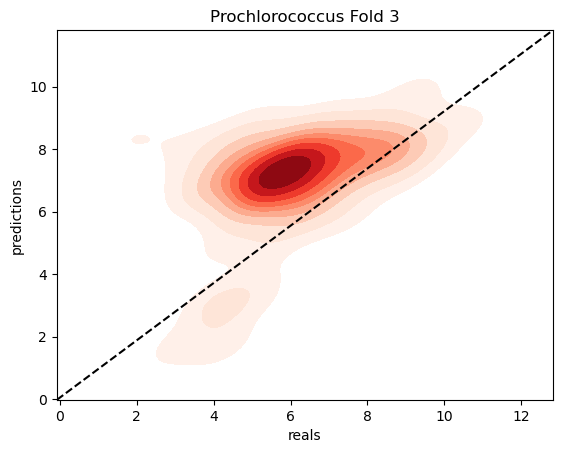

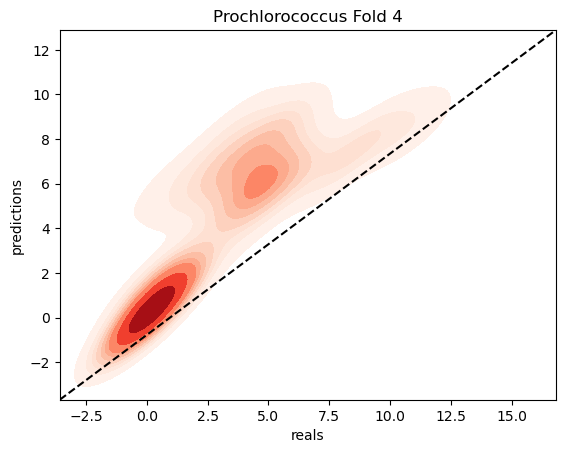

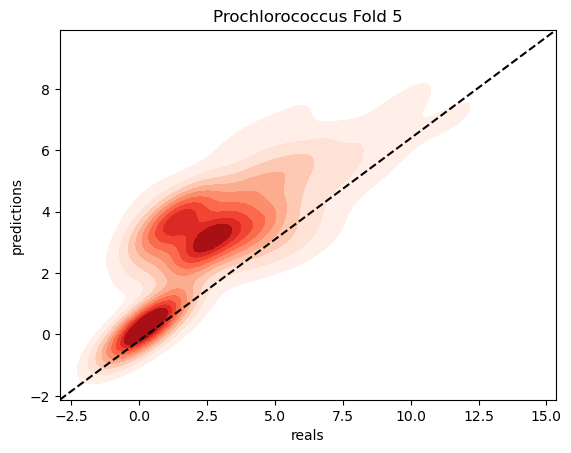

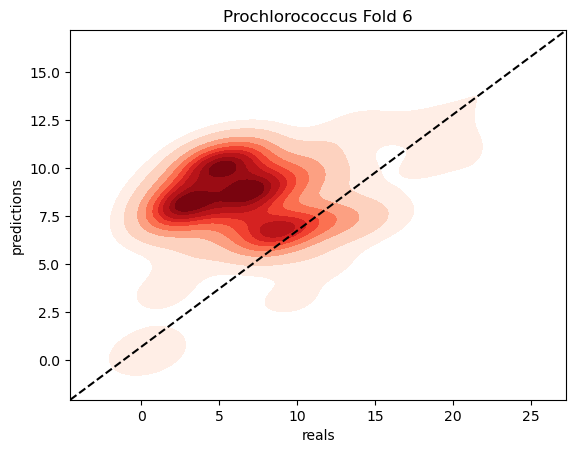

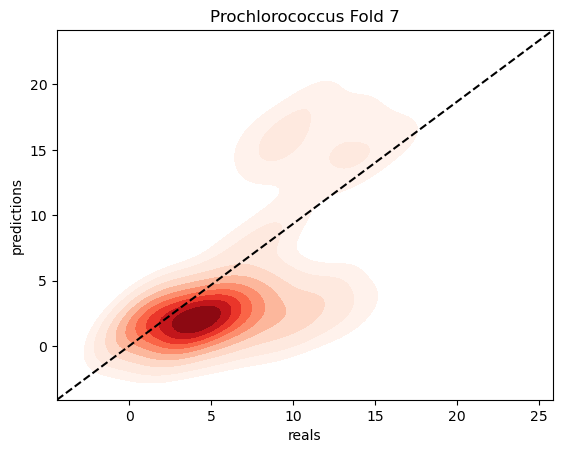

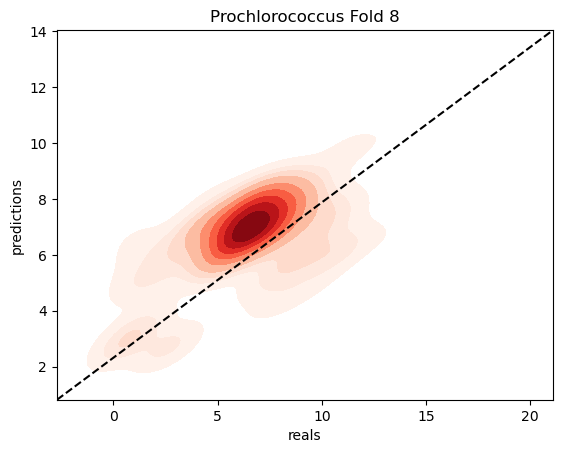

In [54]:
# Import necessary libraries
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd
#suppress future warnings (since we are version controlled and don't need to see them)
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)


#plot for each fold reals vs preds on that fold's test data
for f in fold:
    actual = pd.read_csv(f'actual_pro{f}.csv')
    # #Create scatter reals v preds
    #sns.scatterplot(x='reals', y='predictions', data=actual)
    #create density plot
    sns.kdeplot(x='reals', y='predictions', data=actual, fill=True, cmap="Reds", thresh=0.05)
    # Add a reference line from (0,0) to (1,1)
    plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, ls='--', c='black')

    # #linear regression line
    # x = data['reals']
    # y = data['predictions']
    # slope, intercept = np.polyfit(x, y, 1)
    # plt.plot(x, slope*x + intercept, color='blue', label='Linear Regression')
    
    plt.title(f'Prochlorococcus Fold {f+1}')
    plt.savefig(f'pro_fold{f+1}.png')
    plt.show()

In [55]:
print(confidence[:3])
print(predictions[:3])

[1.23600215 1.31393571 1.05232126]
[6.60980631 6.2915189  6.08473369]


In [56]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def create_fold_predictions_time(pop_df, title_prefix='Prochlorococcus'):
    """
    Makes an actual vs prediction plot for each fold by time
    """
    unique_cruises = merged_df['cruisename'].unique()

    # Create a subplot grid
    num_cruises = len(unique_cruises)
    rows = int(num_cruises / 2) if num_cruises % 2 == 0 else int(num_cruises / 2) + 1
    fig = make_subplots(rows=rows, cols=2, subplot_titles=unique_cruises)

    # Define colors for 'actual' and 'prediction' traces
    #actual_color = 'blue'
    prediction_color = 'red'

    # Define colors for actuals from each fold test data
    colors = ['blue', 'green'] 

    # Initialize a counter for the color of each point
    point_counter = 0  

    #determine y range
    y_range = [merged_df[['biomass', 'prediction']].min().min() - 1, merged_df[['biomass', 'prediction']].max().max()+1]
    print(y_range)



    # Iterate over each unique cruise and add a subplot
    for i, cruise in enumerate(unique_cruises):
        # Filter dataframe for the current cruise
        cruise_df = merged_df[merged_df['cruisename'] == cruise]

        # Create a color list for the current cruise
        cruise_color_list = [colors[(point_counter + j) // 299 % len(colors)] for j in range(len(cruise_df))]

        # Update the point counter
        point_counter += len(cruise_df)
        print(len(cruise_df))
        print(point_counter)
        # Add the scatter plots for 'actual' and 'prediction' to the subplot
        row = int(i / 2) + 1
        col = i % 2 + 1
        fig.add_trace(go.Scatter(x=cruise_df['time'], y=cruise_df['biomass'], mode='markers', name='Actual',
                                marker=dict(color=cruise_color_list)),
                    row=row, col=col)
        fig.add_trace(go.Scatter(x=cruise_df['time'], y=cruise_df['prediction'], mode='lines', name='Prediction',
                                line=dict(color=prediction_color)),
                    row=row, col=col)
        fig.update_xaxes(title_text='Time', row=row, col=col)
        fig.update_yaxes(title_text='Biomass (pCg/L)', row=row, col=col)
        #set y range
        fig.update_yaxes(range=y_range, row=row, col=col)
        # Add confidence interval
        fig.add_trace(go.Scatter(
            x=cruise_df['time'],
            y=cruise_df['prediction'] + cruise_df['confidence'],
            mode='lines',
            marker=dict(color="#444"),
            line=dict(width=0),
            showlegend=False),
            row=row, col=col)
        fig.add_trace(go.Scatter(
            x=cruise_df['time'],
            y=cruise_df['prediction'] - cruise_df['confidence'],
            marker=dict(color="#444"),
            line=dict(width=0),
            mode='lines',
            fillcolor='rgba(68, 68, 68, 0.3)',
            fill='tonexty',
            showlegend=False),
            row=row, col=col)

    # Update the layout and display the figure
    fig.update_layout(height=600 * rows, width=1200, title_text='Actual and Prediction for Each Cruise')
    fig.show()


   


In [57]:
create_fold_predictions_time(merged_df, title_prefix='Prochlorococcus')

[-0.994946753, 23.361795]
316
316
189
505
273
778
149
927
400
1327
276
1603
542
2145
248
2393


In [58]:
# import pandas as pd
# import numpy as np

# PoConf = confidence/predictions * 100
day_bin_df = merged_df
day_bin_df['time'] = pd.to_datetime(day_bin_df['time'])

# # Reassign the DataFrame after selecting the numeric columns
day_bin_df.set_index('time', inplace=True)
day_bin_df = day_bin_df.select_dtypes(include=[np.number])


day_avg_df = day_bin_df.resample('D').mean()
day_avg_df.reset_index(inplace=True)
day_avg_df.head(3)

,time,lat,lon,biomass,salin,temp,SiO2,POSi,PON,POFe,...,DON,DOFe,DOC,DIC,CDOM,ALK,par,hours_since_sunrise,prediction,confidence
0,2016-04-20,22.604705,-158.188163,8.160274,35.047305,23.969339,-0.021600,-0.000117,0.004309,3.358392e-07,...,0.225117,0.000016,1.439053,1701.681497,0.000029,1957.273260,441.153149,12.983007,5.960819,1.084474
1,2016-04-21,23.848006,-157.961973,7.701395,35.274657,22.686782,-0.020202,-0.000108,0.003514,2.765868e-07,...,0.196038,0.000014,1.216400,1706.587647,0.000024,1960.139512,563.583277,12.413600,6.296697,1.175421
2,2016-04-22,26.665721,-157.999844,6.706331,35.201564,20.749137,-0.011756,-0.000031,0.002318,1.837895e-07,...,0.177651,0.000013,1.096056,1728.188491,0.000021,1973.511093,621.757027,11.477604,7.041538,1.105056


In [59]:
import plotly.graph_objects as go
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd
#suppress future warnings (since we are version controlled and don't need to see them)
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

fig = go.Figure()

fig.add_trace(go.Scatter(y=day_bin_df['biomass'], mode='markers', name='Actual',
                        marker=dict(color='blue')))
fig.add_trace(go.Scatter(y=day_bin_df['prediction'], mode='lines', name='Prediction',
                        line=dict(color='red')))

fig.update_yaxes(range=[-1,24])
# Add confidence interval
fig.add_trace(go.Scatter(
    
    y=day_bin_df['prediction'] + day_bin_df['confidence'],
    mode='lines',
    marker=dict(color="#444"),
    line=dict(width=0),
    showlegend=False))
fig.add_trace(go.Scatter(
    
    y=day_bin_df['prediction'] - day_bin_df['confidence'],
    marker=dict(color="#444"),
    line=dict(width=0),
    mode='lines',
    fillcolor='rgba(68, 68, 68, 0.3)',
    fill='tonexty',
    showlegend=False))


## Predicting and Testing for Prochlorococus

Now that we have a model, it's time to test it.  These following functions compare the predictions from out random forest model to actual data, and then use this comparison to give us feature importance.  

In [60]:
# for f in fold:
#     # Convert test_features to a DataFrame
#     test_features_df = pd.DataFrame(test_features[f], columns=feature_list_pro)

#     # Use the forest's predict method on the test data
#     predictions = rf.predict(test_features[f])

#     # Create a new Series with predicted values and index from test_features_df
#     predic_biomass = pd.Series(predictions, index=test_features_df.index)

#     # Assign the new Series to the DataFrame using .loc
#     test_features_df.loc[:, 'Prediction'] = predic_biomass

#     # Calculate the absolute errors
#     errors = abs(predictions - test_labels)

#     # Print out the mean absolute error (mae)
#     from sklearn.metrics import mean_absolute_error
#     mae = mean_absolute_error(test_labels[f], predictions)
#     print('Mean Absolute Error:', round(mae, 2), 'pgC per L.')

#     # Finding the root mean square error (RMSE)
#     from sklearn.metrics import mean_squared_error
#     # RMSE give realtively high weight to large errors 
#     RMSE = mean_squared_error(test_labels[f], predictions, squared=False) #setting squared=False gives us RMSE not MSE

#     # Calculate the percentage of RMSE
#     range_target = test_labels.max() - test_labels.min()
#     percentage_RMSE = (RMSE / range_target) * 100

#     print('Root Mean Squared Error:', round(RMSE, 2), 'pgC per L.')
#     print('Percentage of RMSE:', round(percentage_RMSE, 2), '%')


In [61]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list_pro, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

KeyError: 1

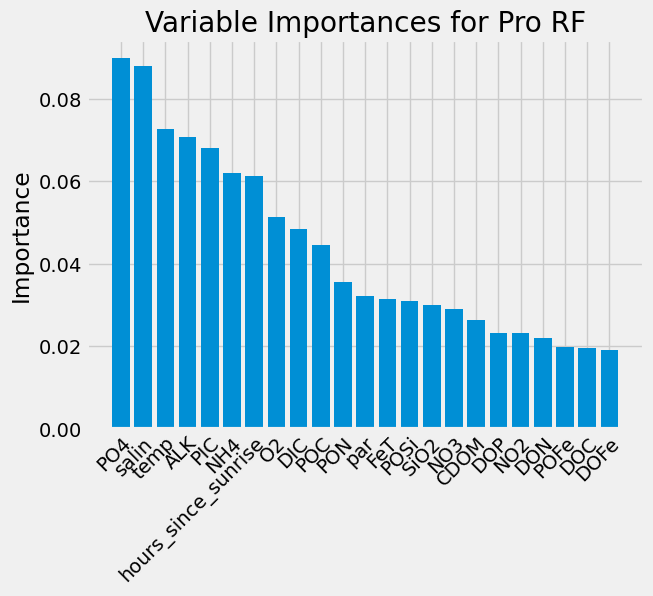

In [64]:
feature_importance = 
for f in fold:
    feat_importance = pd.DataFrame(rf.feature_importances_, index=feature_list_pro).sort_values(by=0, ascending=False)

# Import matplotlib for plotting and use magic command for Jupyter Notebooks
import matplotlib.pyplot as plt
%matplotlib inline
for f in fold:
    # Set the style
    plt.style.use('fivethirtyeight')
    # Make a bar chart
    plt.bar(x=feature_importance.index,height=feature_importance[f], orientation = 'vertical')
    # Tick labels for x axis
    plt.xticks(feature_importance.index, rotation=45, ha='right', rotation_mode='anchor')

    # Axis labels and title
    plt.ylabel('Importance'); plt.title('Variable Importances for Pro RF')

### Permutation importance as a method of assessing feature importance

Permutation importance tests feature importance by permuting branches on RF trees to asses the impact of changing specific variables on the prediction.  This is an additional way to validate our feature importance.

In [63]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    rf, test_features, test_labels, n_repeats=10, random_state=42, n_jobs=2
)


forest_importances = pd.DataFrame(result.importances_mean, index=feature_list_pro).sort_values(by=0, ascending=False)
forest_importances.to_csv('data/modified/pro_permutation_importance.csv', index=False)


ValueError: Found array with dim 3. None expected <= 2.

In [ ]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

### Comparing predicted biomass vs actual

In [ ]:
fig, axs = plot_model_predictions()

axs[1].set_title('Prochlorococcus')

In [ ]:
# Call the function and store the figure and axes objects
# Assuming plot_model_predictions_density() generates a plot and returns the figure and axes objects
fig, ax = plot_model_predictions_density()

# Set the title for the single subplot
ax.set_xlim(0, 15)  # Example x-axis limits
ax.set_ylim(0, 15)  # Example y-axis limits
    
ax.set_title('Prochlorococcus', fontsize=20)



# Display Legend
ax.legend(loc="lower right", )

plt.tick_params(axis='both', which='major', labelsize=16)  # Adjust the fontsize




# Display the plot with the updated title
plt.show()


In [ ]:
from sklearn.metrics import r2_score
r2_score(test_labels[ftu], predictions)